## Neural network 의 성능 고도화

이전에 MLP 의 기본적인 backbone 을 구현했다면, 이번에는 딥러닝 성능을 고도화 방법을 구현해본다.

### Content
0. Setting
    - 환경변수
    - MNIST Dataset
1. Dropout
2. Batch Norimlization
3. Optimizers
    - SGD
    - Momentum
    - Nesterov
    - AdaGrad
    - RMSProp
    - Adam

In [1]:
import os
import sys
import random
import platform
import warnings
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import OrderedDict
from nn_mnist import *
from nn_model import *
from nn_optimizer import *
from nn_trainer import *

#### 0-1. 환경변수

In [2]:
# 재현성을 위해 랜덤 시드를 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# 현재 OS 및 라이브러리 버전 체크 체크
current_os = platform.system()
print(f"Current OS: {current_os}")
print(f"Python Version: {platform.python_version()}")

# 중요하지 않은 에러 무시
warnings.filterwarnings(action='ignore')

# 유니코드 깨지는 현상 해결
mpl.rcParams['axes.unicode_minus'] = False

Current OS: Darwin
Python Version: 3.11.5


#### 0-2. MNIST Dataset

In [3]:
mnist = MNIST()
# MNIST 데이터셋 다운로드
mnist.download_dataset()

# MNIST 데이터셋 불러오기
mnist.load_mnist()

# 학습 데이터 중 일부를 검증 데이터로 활용
mnist.suffle_validation()

In [4]:
# MNIST 데이터셋 살펴보기
print(f"학습 데이터: {len(mnist.X_train):,}개\n검증 데이터: {len(mnist.X_valid):,}개\n평가 데이터: {len(mnist.X_test):,}개")

학습 데이터: 50,000개
검증 데이터: 10,000개
평가 데이터: 10,000개


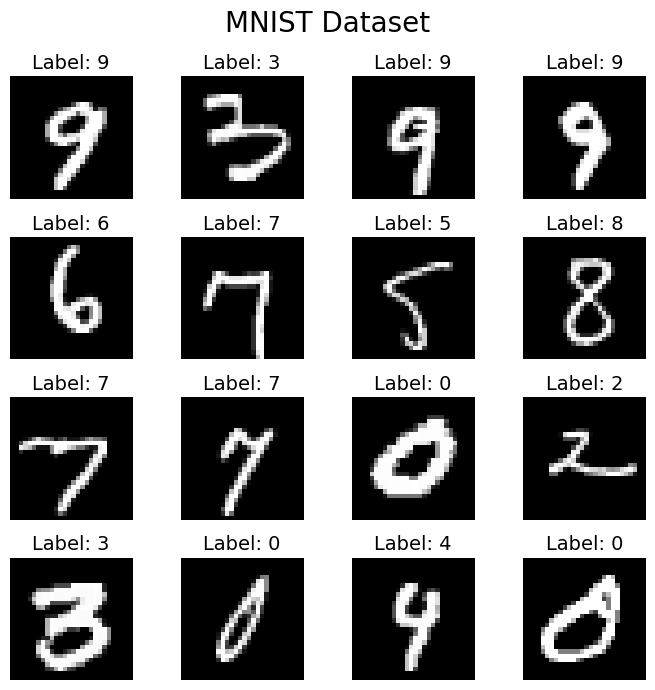

In [5]:
mnist.dataset_visualization()

In [6]:
# 이후 편의를 위해 데이터셋을 변수로 할당
X_train = mnist.X_train
y_train = mnist.y_train
X_valid = mnist.X_valid
y_valid = mnist.y_valid
X_test = mnist.X_test
y_test = mnist.y_test

[Elpased Time: 0:00:00.029267] Iter:    0 Train Loss : 2.3175 Train Acc : 0.13 Valid Loss : 2.3368 Valid Acc : 0.15 
[Elpased Time: 0:00:00.674791] Iter:  100 Train Loss : 1.2436 Train Acc : 0.77 Valid Loss : 1.4375 Valid Acc : 0.68 
[Elpased Time: 0:00:01.138758] Iter:  200 Train Loss : 0.4637 Train Acc : 0.95 Valid Loss : 0.9648 Valid Acc : 0.72 
[Elpased Time: 0:00:01.589529] Iter:  300 Train Loss : 0.2867 Train Acc : 0.97 Valid Loss : 0.8671 Valid Acc : 0.73 
[Elpased Time: 0:00:02.094253] Iter:  400 Train Loss : 0.1699 Train Acc : 0.98 Valid Loss : 0.7860 Valid Acc : 0.75 
[Elpased Time: 0:00:02.666409] Iter:  500 Train Loss : 0.1284 Train Acc : 1.00 Valid Loss : 0.6733 Valid Acc : 0.77 
[Elpased Time: 0:00:03.171508] Iter:  600 Train Loss : 0.0712 Train Acc : 1.00 Valid Loss : 0.6049 Valid Acc : 0.80 
[Elpased Time: 0:00:03.715723] Iter:  700 Train Loss : 0.0574 Train Acc : 1.00 Valid Loss : 0.5574 Valid Acc : 0.80 
[Elpased Time: 0:00:04.117250] Iter:  800 Train Loss : 0.0414 Tr

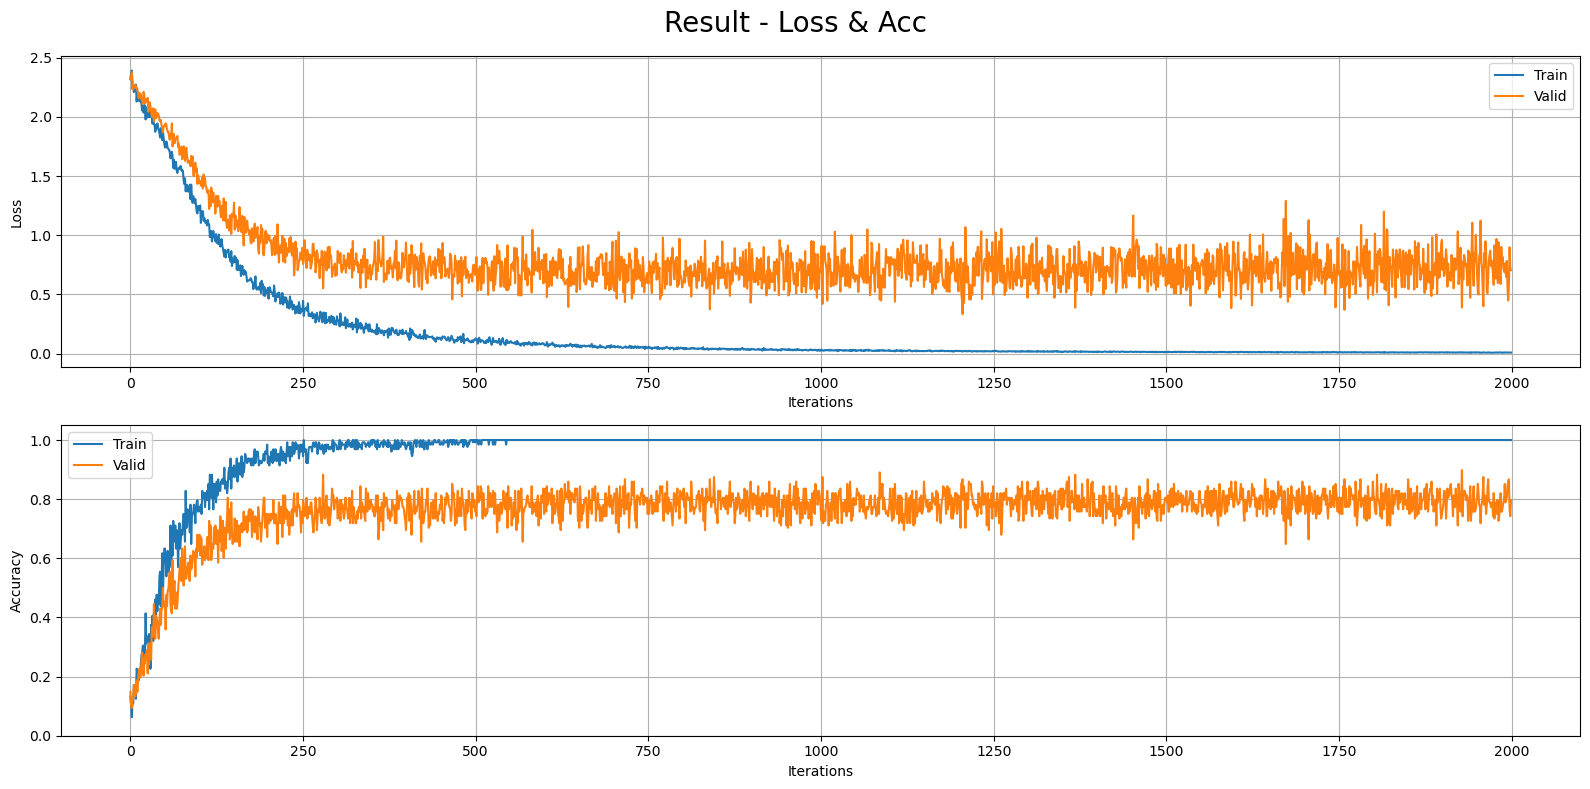

In [7]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_dropout=False,
    use_batchnorm=False,
    weight_decay_lambda=0,
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_base = Trainer(
    X_train[:200], y_train[:200], # 과적합을 발생시키기 위해 모델에 비해 데이터셋이 부족하게 설정
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_base.run()

# 결과 시각화
trainer_base.show_results()

- Train Data 에 대하여 Loss 가 0, Accuracy 가 1 로 모델이 과적합된 것을 확인할 수 있다.

#### `DropOut`
* 학습 시 일부 뉴런을 무작위로 꺼버리는 방식으로 동작하며, 이로 인해 모델이 특정 뉴런에만 의존하지 않게 되어 과적합을 방지할 수 있다.
* <-> 드롭아웃 기법은 학습 중 일부 뉴런을 무작위로 '꺼버려서' 모델이 특정 뉴런들에 지나치게 의존하는 것을 방지한다. 이를 통해 과적합을 방지할 수 있다.
* 마스크는 학습 시 사용되는 불리언 배열로, 어떤 뉴런을 꺼버릴지 결정한다. True인 뉴런은 활성화 상태를 유지하고, False인 뉴런은 꺼버린다.
* 테스트 시에는 모든 뉴런을 사용하지만, 출력을 스케일링하여 학습 때 끄게 되는 뉴런의 비율을 반영한다. 이는 학습 때와 테스트 때의 활성 뉴런 수가 동일한것 처럼 작동한다.
* 역전파 시에는, 순전파 때 꺼진 뉴런에는 그래디언트가 전달되지 않도록 한다.

[Elpased Time: 0:00:00.032300] Iter:    0 Train Loss : 2.3184 Train Acc : 0.11 Valid Loss : 2.3056 Valid Acc : 0.15 
[Elpased Time: 0:00:00.690514] Iter:  100 Train Loss : 2.2952 Train Acc : 0.11 Valid Loss : 2.3013 Valid Acc : 0.15 
[Elpased Time: 0:00:01.328852] Iter:  200 Train Loss : 2.2836 Train Acc : 0.12 Valid Loss : 2.2797 Valid Acc : 0.21 
[Elpased Time: 0:00:01.842215] Iter:  300 Train Loss : 2.2759 Train Acc : 0.16 Valid Loss : 2.2862 Valid Acc : 0.17 
[Elpased Time: 0:00:02.398882] Iter:  400 Train Loss : 2.2822 Train Acc : 0.18 Valid Loss : 2.2834 Valid Acc : 0.17 
[Elpased Time: 0:00:03.060905] Iter:  500 Train Loss : 2.2588 Train Acc : 0.17 Valid Loss : 2.2760 Valid Acc : 0.13 
[Elpased Time: 0:00:03.653613] Iter:  600 Train Loss : 2.2295 Train Acc : 0.24 Valid Loss : 2.2596 Valid Acc : 0.21 
[Elpased Time: 0:00:04.103729] Iter:  700 Train Loss : 2.2378 Train Acc : 0.18 Valid Loss : 2.2279 Valid Acc : 0.26 
[Elpased Time: 0:00:04.765514] Iter:  800 Train Loss : 2.2156 Tr

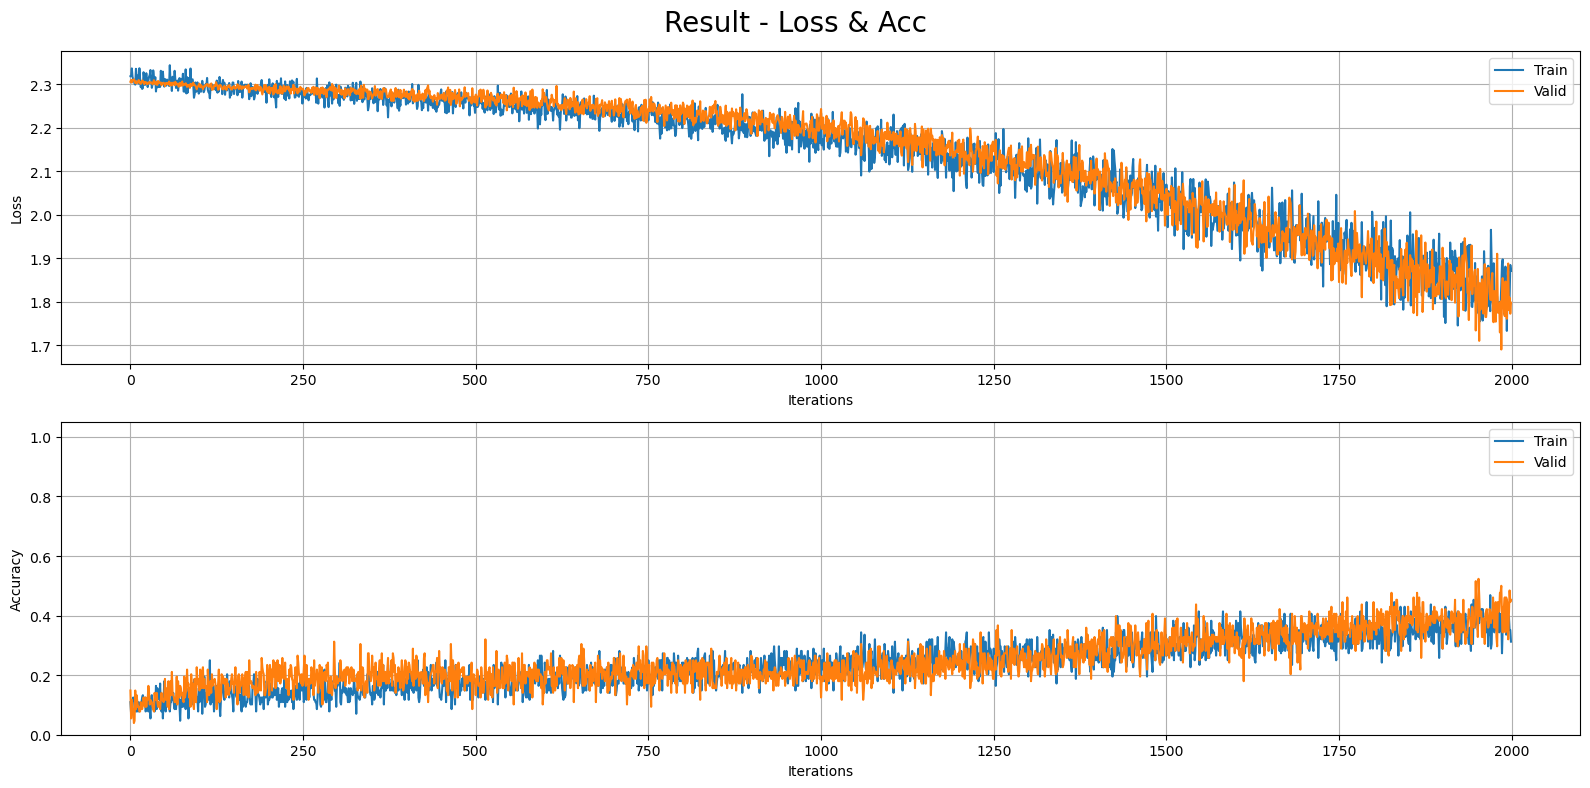

In [18]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_dropout=True,  # 드롭아웃을 사용해봅시다.
    dropout_ratio=0.5, # 비율을 다양하게 바꿔 실험해봅시다.
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_dropout = Trainer(
    X_train[:200], y_train[:200], # 과적합을 발생시키기 위해 모델에 비해 데이터셋이 부족하게 설정
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_dropout.run()

# 결과 시각화
trainer_dropout.show_results()

- Dropout 을 사용하지 않은 것에 비해 큰 성능 향상을 보이지는 않지만, 학습 양상을 보면 과적합의 시기가 늦춰지고 있는 것을 확인할 수 있다.
- [Dropout 논문](https://arxiv.org/abs/1207.0580)

#### `가중치 초기화`
*  가중치 초기화는 딥 러닝에서 매우 중요하다. 잘못된 초기화는 학습 속도를 느리게 하거나, 학습이 전혀 이루어지지 않게 할 수 있다.
* Xavier 초기화는 활성화 함수로 Sigmoid나 Hyperbolic Tangent를 사용할 때 권장되며, 입력 뉴런의 수로 스케일링되어 가중치를 초기화한다.
* He 초기화는 ReLU와 그 변형을 활성화 함수로 사용할 때 권장된다. 입력 뉴런의 수의 절반으로 스케일링되어 가중치를 초기화한다.

##### `Xavier`

[Elpased Time: 0:00:00.111375] Iter:    0 Train Loss : 2.3228 Train Acc : 0.09 Valid Loss : 2.3191 Valid Acc : 0.09 
[Elpased Time: 0:00:00.902199] Iter:  100 Train Loss : 2.3019 Train Acc : 0.11 Valid Loss : 2.3231 Valid Acc : 0.08 
[Elpased Time: 0:00:01.508803] Iter:  200 Train Loss : 2.3290 Train Acc : 0.10 Valid Loss : 2.3296 Valid Acc : 0.05 
[Elpased Time: 0:00:02.324637] Iter:  300 Train Loss : 2.3152 Train Acc : 0.12 Valid Loss : 2.3173 Valid Acc : 0.12 
[Elpased Time: 0:00:03.449948] Iter:  400 Train Loss : 2.2996 Train Acc : 0.20 Valid Loss : 2.2850 Valid Acc : 0.14 
[Elpased Time: 0:00:04.186381] Iter:  500 Train Loss : 2.2902 Train Acc : 0.12 Valid Loss : 2.2972 Valid Acc : 0.10 
[Elpased Time: 0:00:05.091221] Iter:  600 Train Loss : 2.3234 Train Acc : 0.16 Valid Loss : 2.3271 Valid Acc : 0.08 
[Elpased Time: 0:00:05.690864] Iter:  700 Train Loss : 2.3018 Train Acc : 0.12 Valid Loss : 2.2910 Valid Acc : 0.15 
[Elpased Time: 0:00:06.226842] Iter:  800 Train Loss : 2.3696 Tr

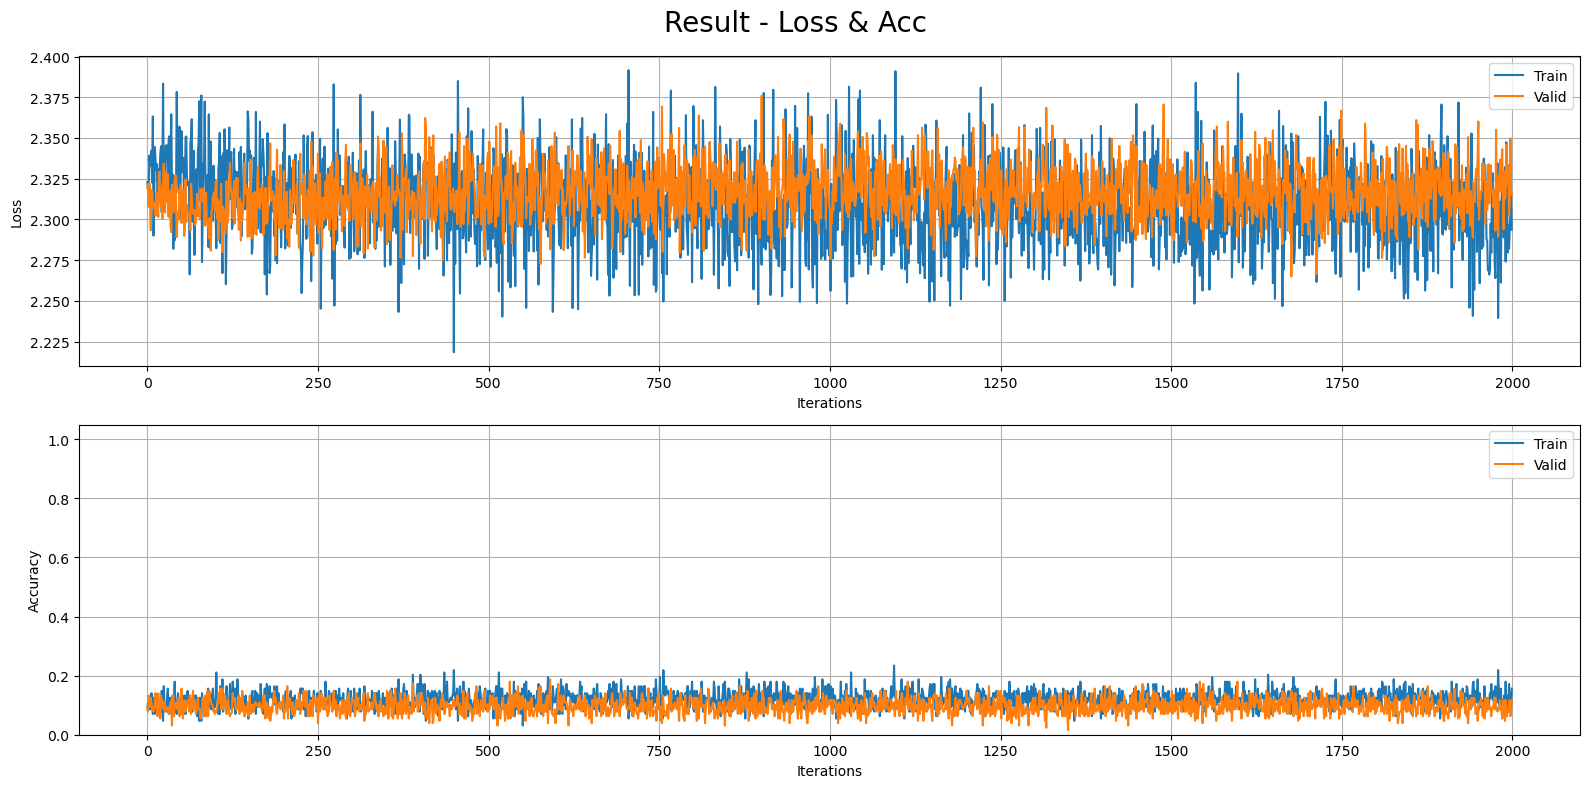

In [9]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_dropout=True,
    dropout_ratio=0.5,
    weight_init_std='xavier',
    activation='sigmoid',
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_xavier = Trainer(
    X_train[:200], y_train[:200],
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_xavier.run()

# 결과 시각화
trainer_xavier.show_results()

##### `He`

[Elpased Time: 0:00:00.083997] Iter:    0 Train Loss : 2.3195 Train Acc : 0.07 Valid Loss : 2.2963 Valid Acc : 0.12 
[Elpased Time: 0:00:00.809707] Iter:  100 Train Loss : 2.3011 Train Acc : 0.19 Valid Loss : 2.2884 Valid Acc : 0.16 
[Elpased Time: 0:00:01.600670] Iter:  200 Train Loss : 2.2807 Train Acc : 0.09 Valid Loss : 2.2724 Valid Acc : 0.22 
[Elpased Time: 0:00:02.183909] Iter:  300 Train Loss : 2.2485 Train Acc : 0.19 Valid Loss : 2.2599 Valid Acc : 0.25 
[Elpased Time: 0:00:02.808292] Iter:  400 Train Loss : 2.2581 Train Acc : 0.17 Valid Loss : 2.2320 Valid Acc : 0.20 
[Elpased Time: 0:00:03.303580] Iter:  500 Train Loss : 2.2328 Train Acc : 0.26 Valid Loss : 2.2367 Valid Acc : 0.20 
[Elpased Time: 0:00:04.057617] Iter:  600 Train Loss : 2.2097 Train Acc : 0.17 Valid Loss : 2.2191 Valid Acc : 0.29 
[Elpased Time: 0:00:04.716086] Iter:  700 Train Loss : 2.1670 Train Acc : 0.29 Valid Loss : 2.1994 Valid Acc : 0.29 
[Elpased Time: 0:00:05.487092] Iter:  800 Train Loss : 2.2046 Tr

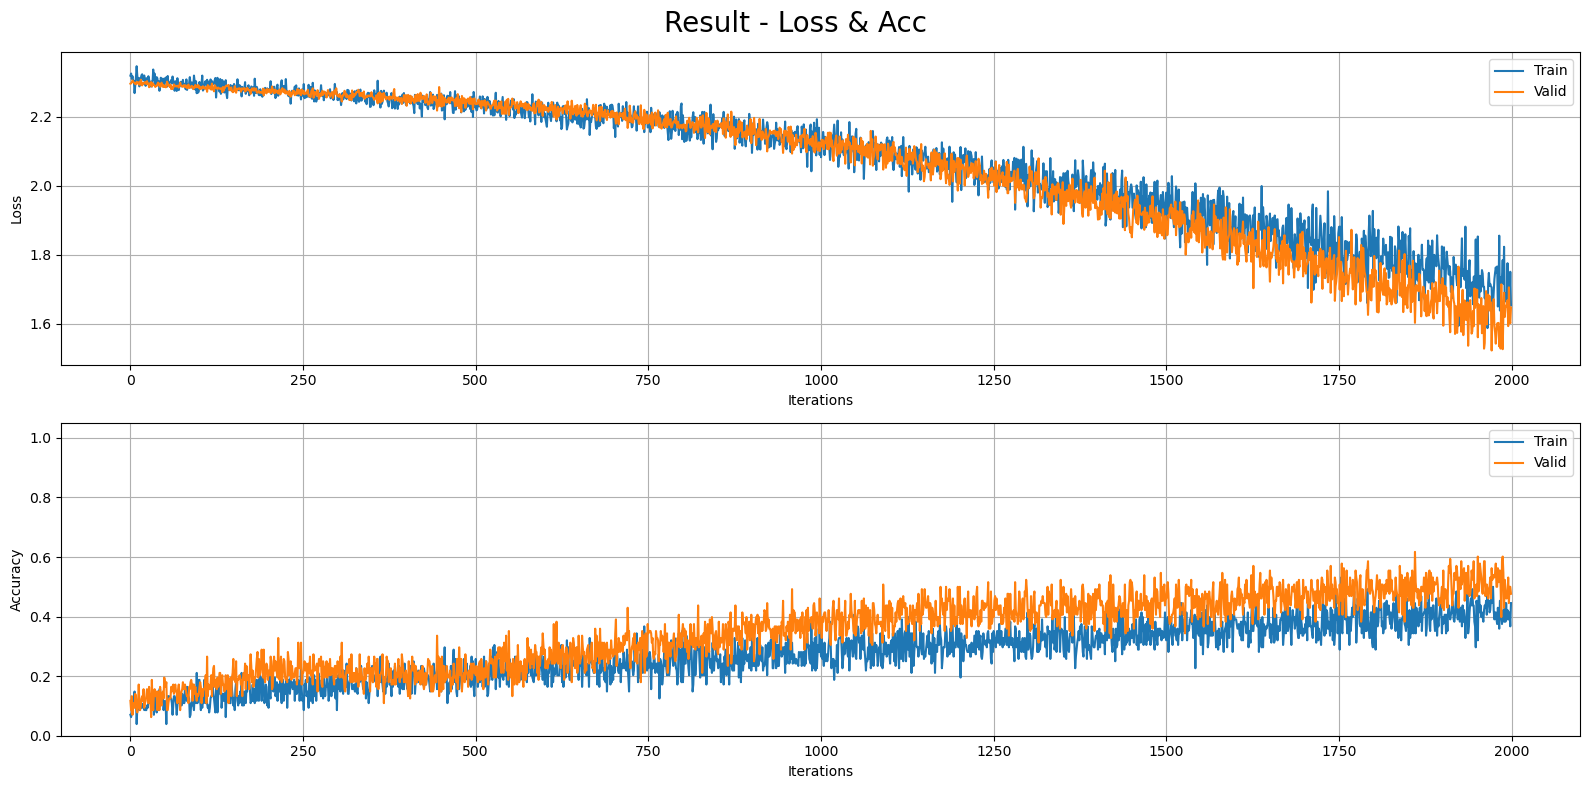

In [14]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_dropout=True,
    dropout_ratio=0.5,
    weight_init_std='he',
    activation='relu', 
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_he = Trainer(
    X_train[:200], y_train[:200], 
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_he.run()

# 결과 시각화
trainer_he.show_results()

- 성능이 매우 좋지 않게 나왔다.
- 데이터가 너무 적거나, random state 의 영향일 수 있다.

#### `Batch Normalization`
* 배치 정규화는 심층 신경망의 내부에서 활성화값이 특정 분포를 유지하도록 도와 학습을 안정화하고 속도를 빠르게 하는 기법이다.
* 기본 아이디어는 네트워크의 각 층의 활성화값이 너무 크거나 작게 되지 않도록 조정함으로써, 네트워크의 학습을 보다 빠르고 안정적으로 만드는 것이다.
* 학습 시에는 현재 배치의 평균과 분산을 계산하여 정규화를 수행하고, 평가 시에는 학습 동안의 움직이는 평균과 분산을 사용하여 정규화한다.
* `running_mean` 및 `running_var` (즉, 이동 평균과 분산)은 학습 중 배치 정규화의 안정성과 테스트 시의 일관성을 위해 도입되었다. 그러나 그것들이 항상 필요하다고는 할 수 없다. 필요성은 여러 상황에 따라 달라진다. `running_mean`과 `running_var` 사용하면, 모델이 학습 중과 테스트 중에 동일한 방식으로 동작하는 것을 보장할 수 있다.
* 테스트나 추론(inference) 시에는 종종 배치 크기가 1이거나 예측하려는 샘플 수에 따라 다양하다. 이 경우 각 샘플 또는 작은 배치의 평균과 분산을 계산하는 것은 불안정할 수 있다. 이 때 `running_mean`과 `running_var` 학습 중에 축적된 평균적인 정보를 제공하여 추론을 안정화한다. 물론, 특정 상황에서는 `running_mean`과 `running_var` 없이도 잘 작동하는 경우도 있다. 예를 들어, 배치 크기가 충분히 크고 데이터의 분포가 학습 데이터와 테스트 데이터에서 크게 달라지지 않는 경우에는 꼭 필요하지 않을 수 있다. 결론적으로, 이동 평균과 분산을 사용하는 것은 일반적인 권장 사항이지만, 항상 필요한 것은 아니다. 


[Elpased Time: 0:00:00.157770] Iter:    0 Train Loss : 2.5832 Train Acc : 0.09 Valid Loss : 2.2645 Valid Acc : 0.15 
[Elpased Time: 0:00:00.939412] Iter:  100 Train Loss : 2.2016 Train Acc : 0.23 Valid Loss : 1.9698 Valid Acc : 0.33 
[Elpased Time: 0:00:01.656606] Iter:  200 Train Loss : 2.0947 Train Acc : 0.27 Valid Loss : 1.8850 Valid Acc : 0.40 
[Elpased Time: 0:00:02.286929] Iter:  300 Train Loss : 1.8702 Train Acc : 0.37 Valid Loss : 1.4936 Valid Acc : 0.64 
[Elpased Time: 0:00:03.065889] Iter:  400 Train Loss : 1.8227 Train Acc : 0.41 Valid Loss : 1.4899 Valid Acc : 0.55 
[Elpased Time: 0:00:03.669618] Iter:  500 Train Loss : 1.7461 Train Acc : 0.42 Valid Loss : 1.4280 Valid Acc : 0.56 
[Elpased Time: 0:00:04.271347] Iter:  600 Train Loss : 1.5859 Train Acc : 0.55 Valid Loss : 1.1511 Valid Acc : 0.78 
[Elpased Time: 0:00:04.840492] Iter:  700 Train Loss : 1.6015 Train Acc : 0.48 Valid Loss : 1.1329 Valid Acc : 0.71 
[Elpased Time: 0:00:05.424918] Iter:  800 Train Loss : 1.4284 Tr

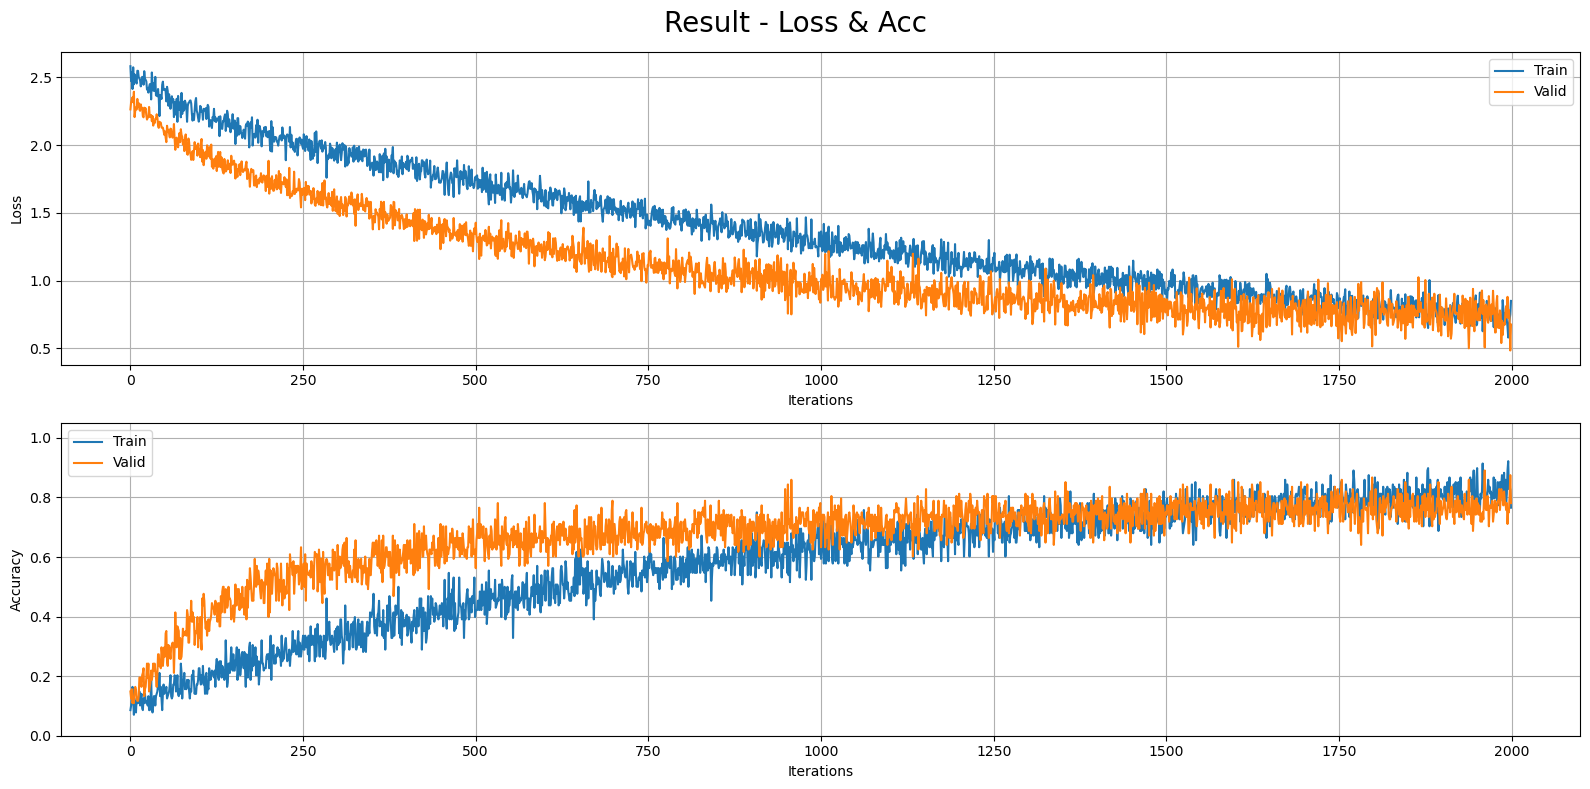

In [15]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
    use_batchnorm=True,  
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_batchnorm = Trainer(
    X_train[:200], y_train[:200],
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_batchnorm.run()

# 결과 시각화
trainer_batchnorm.show_results()

- 위 Weight initialization 이 올바르게 되지 않았음에도, 처음의 Iteration 이후 weight 를 안정화시켜줌을 예상해볼 수 있다.
 - 이에 따라 모델의 성능이 향상하며, 과적합 역시 줄어든 것으로 보여진다.

##### `드롭아웃, 가중치 초기화 그리고 배치 정규화 성능 비교하기`
드롭아웃만 활용했을 경우보다, 가중치 초기화와 배치 정규화를 활용하는 경우가 더욱 오차가 확연히 줄어든 것을 확인할 수 있다.

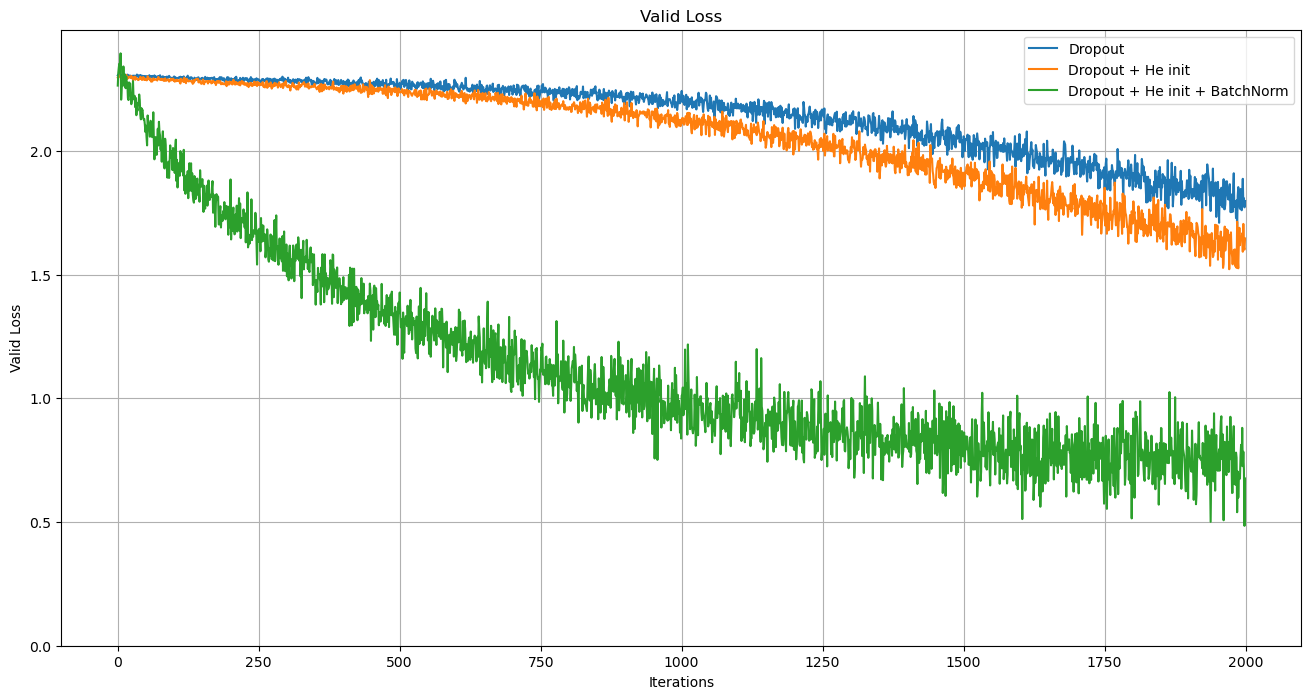

In [19]:
plt.figure(figsize=(16,8))

plt.plot(trainer_dropout.valid_loss_list)
plt.plot(trainer_he.valid_loss_list)
plt.plot(trainer_batchnorm.valid_loss_list)

plt.xlabel('Iterations')
plt.ylabel('Valid Loss')
plt.legend(['Dropout', 'Dropout + He init', 'Dropout + He init + BatchNorm'])
plt.ylim(0,)

plt.title('Valid Loss')
plt.grid(True)
plt.show()